# Lonlat ms diagnosis on main combination - in areas

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

import matplotlib.transforms as mtransforms
crs = ccrs.PlateCarree()

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter, lonlat_stats
from histlib.cstes import labels, zarr_dir, matchup_dir, c0, U
U2 =U**2

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


________
__________
# Get areas
## Load data

In [2]:
DL, DT = 25e3, 30*60
comb_25 = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
dsm = xr.open_dataset(path_csv(comb_25, 'both', True, DL, DT).replace('analysis_files/', 'analysis_files/lonlat_').replace('.csv', '.nc'))


# re-Scale with U2
vars_errors = ['B_acc', 'E_acc', 'E_cor', 'B_cor', 'E_ggx', 'B_ggx', 'E_wd', 'B_wd',
 'X_acc_cor', 'X_acc_ggx', 'X_acc_wd', 'X_cor_ggx', 'X_cor_wd','X_ggx_wd', 
 'ACC', 'COR', 'GGX', 'WD', 'S', 'sigma']
vars = ['acc_cor','acc_ggx','acc_wd','cor_ggx','cor_wd','ggx_wd',
 'E_acc','B_acc','E_cor','B_cor','E_ggx','B_ggx','E_wd','B_wd',
 'X_acc_cor','X_acc_ggx','X_acc_wd','X_cor_ggx','X_cor_wd','X_ggx_wd',
 'ACC','COR','GGX','WD','S','sigma',] + ['be__'+v for v in vars_errors]
for v in vars :
    dsm[v] = dsm[v]/U2

# Relative error
for v in vars_errors :
    dsm['ratio__'+v] = abs(dsm['be__'+v]/dsm[v])
    
# sigma percentage
for v in [v for v in dsm if 'X' in v] :
    dsm[v+'__sigma'] = dsm[v]/dsm['sigma']*100

In [3]:
ds = dsm

## Create areas

In [4]:
# Gulf Stream 
area_geo = ds['X_cor_ggx__sigma']>70
gulf_stream = area_geo.where(area_geo.lonbin<-10, False).where(area_geo.latbin>15, False).where(area_geo.lonbin>-85, False).where(area_geo.latbin<50, False)
# ACC 
testlat = (ds.latbin<-35)
area_geo = ds['X_cor_ggx__sigma']>45
acc = area_geo.where(testlat, False)
# North Pacific
area_geo = ds['X_acc_cor__sigma']>10
testlon = (ds.lonbin<-120)| (ds.lonbin>150)
testlat = (ds.latbin>40)
north_pacific = area_geo.where(testlat & testlon, False)
# Tropics
area_geo = ds['X_cor_ggx__sigma']<1e10
testlat = (ds.latbin<15)&(ds.latbin>-15)
tropics = area_geo.where(testlat, False)

areas = {'GS':gulf_stream, 'ACC':acc, 'NP':north_pacific, 'EQ':tropics}
color_areas = {'Gulf Stream':'red', 'ACC':'darkorange', 'North Pacific':'magenta', 'EQ':'salmon'}

def plot_areas(ax, lw=1.5):
    # Gulf Stream
    gulf_stream.plot.contour(ax=ax, levels=1, colors=[color_areas['Gulf Stream']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('GS', (-90, 35), zorder=6, c=color_areas['Gulf Stream'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #ACC
    acc.plot.contour(ax=ax, levels=1, colors=[color_areas['ACC']], linewidths=lw,transform=ccrs.PlateCarree())
    ax.annotate('ACC', (-120, -83), zorder=6, c=color_areas['ACC'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    #Equator
    ax.axhline(-15, lw=lw, c=color_areas['North Pacific'])
    ax.axhline(15, lw=lw, c=color_areas['North Pacific'])
    ax.annotate('EQ', (10, 0), zorder=6, c=color_areas['North Pacific'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))
    # North_pacific
    north_pacific.plot.contour(ax=ax, levels=1, colors=[color_areas['EQ']],linewidths=lw, transform=ccrs.PlateCarree())
    ax.annotate('NP', (-160, 64), zorder=6, c=color_areas['EQ'], bbox=dict(facecolor='w', edgecolor='none', pad=3.0))

In [5]:
## Numbers of coloc per areas
for a in areas : 
    print(a,ds.where(areas[a]).nb_coloc_bin.sum())

GS <xarray.DataArray 'nb_coloc_bin' ()>
array(6282.)
ACC <xarray.DataArray 'nb_coloc_bin' ()>
array(45185.)
NP <xarray.DataArray 'nb_coloc_bin' ()>
array(17720.)
EQ <xarray.DataArray 'nb_coloc_bin' ()>
array(40544.)


In [6]:
areas_mask = xr.merge([areas[area].rename(area) for area in areas]).to_dataframe()

__________
__________
# Create mean files for these areas

In [17]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime='02:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.251:50336/status,
Dashboard: http://10.148.0.251:50336/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.251:46855,Workers: 0
Dashboard: http://10.148.0.251:50336/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [18]:
cluster.close()

In [10]:
DL, DT = 25e3, 30*60
comb_25 = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}

df= pd.read_csv(path_csv(comb_25, 'both', True, DL, DT))

vars_errors = ['B_acc', 'E_acc', 'E_cor', 'B_cor', 'E_ggx', 'B_ggx', 'E_wd', 'B_wd',
 'X_acc_cor', 'X_acc_ggx', 'X_acc_wd', 'X_cor_ggx', 'X_cor_wd','X_ggx_wd', 
 'ACC', 'COR', 'GGX', 'WD', 'S', 'sigma']

In [11]:
def mean_df(df):
    return df.mean()
from scipy.stats import bootstrap
def compute_bootstrap_error(dff):
    #print(len(dff))
    if len(dff)<3:
        return np.nan
    else : 
        data = (dff, )  # samples must be in a sequence
        return bootstrap(data, statistic = mean_df).standard_error

def areas_stats(df, dl=5, vars_errors=vars_errors, areas_mask=areas_mask, areas =['GS', 'ACC', 'NP', 'EQ'] ):
    DFa = dict()
    
    df["latbin"] = (df.lat // dl) * dl
    df["lonbin"] = (df.lon // dl) * dl

    for area in areas :
        df_ = dd.from_pandas(df.set_index(['latbin', 'lonbin']).where(areas_mask[area]).dropna().reset_index(), npartitions=10).persist()
        
        # Mean in bins
        mean = df_.mean().compute()
        
        #count
        mean['nb_coloc_bin'] = len(df_)
    
        # bootstrap errors
        for v in vars_errors :
            mean['be__'+v] = compute_bootstrap_error(df_.reset_index()[vars_errors][v].compute())
    
        DFa[area] = mean
        print(area)
    return pd.DataFrame(DFa).transpose()

    

In [13]:
da = areas_stats(df)
da.to_csv(path_csv(comb_25, 'both', True, DL, DT).replace('analysis_files/', 'analysis_files/areas_'))

GS
ACC
NP
EQ


In [14]:
da

,latbin,lonbin,obs,acc,cor,ggx,wd,alti___distance,alti___time_difference,lat,...,be__X_acc_wd,be__X_cor_ggx,be__X_cor_wd,be__X_ggx_wd,be__ACC,be__COR,be__GGX,be__WD,be__S,be__sigma
GS,36.253582,-58.740051,48259.947469,-1.149480e-07,-1.255559e-06,1.638513e-06,-3.966463e-08,12603.649634,918.315027,38.605494,...,1.445036e-12,7.800009e-11,3.945952e-12,3.894816e-12,3.445929e-12,3.982224e-11,4.368086e-11,8.631527e-13,1.138065e-11,8.098360e-11
ACC,-52.104902,4.797942,51180.273122,1.264108e-07,-2.142487e-07,6.429095e-07,-1.076644e-08,12721.453093,870.350338,-49.567961,...,5.668191e-13,1.377363e-11,1.673108e-12,1.381297e-12,8.926186e-13,7.886207e-12,7.222552e-12,3.881603e-13,2.539270e-12,1.438935e-11
NP,49.530192,-50.790632,54108.209255,1.611326e-08,-2.437611e-07,3.614897e-07,4.727046e-08,12720.407111,860.755982,52.058509,...,1.127238e-12,7.840104e-12,1.940891e-12,1.272381e-12,3.228226e-12,6.392183e-12,7.137637e-12,6.664206e-13,5.035351e-12,1.210652e-11
EQ,0.618341,-20.168336,58516.088620,-5.568376e-08,3.091746e-08,2.565006e-08,-5.397850e-10,12807.803497,879.641180,3.142623,...,3.545778e-14,6.955030e-13,4.024371e-14,5.406265e-14,6.439008e-13,3.427894e-13,1.492774e-12,4.171379e-15,9.934852e-13,1.960323e-12


In [48]:
cluster.close()

______________________
# Fig function

In [7]:
da = pd.read_csv(path_csv(comb_25, 'both', True, DL, DT).replace('analysis_files/', 'analysis_files/areas_')).rename(columns = {'Unnamed: 0':'areas'}).set_index('areas')

In [8]:
da

,latbin,lonbin,obs,acc,cor,ggx,wd,alti___distance,alti___time_difference,lat,...,be__X_acc_wd,be__X_cor_ggx,be__X_cor_wd,be__X_ggx_wd,be__ACC,be__COR,be__GGX,be__WD,be__S,be__sigma
areas,,,,,,,,,,,,,,,,,,,,,
GS,36.253582,-58.740051,48259.947469,-1.149480e-07,-1.255559e-06,1.638513e-06,-3.966463e-08,12603.649634,918.315027,38.605494,...,1.445036e-12,7.800009e-11,3.945952e-12,3.894816e-12,3.445929e-12,3.982224e-11,4.368086e-11,8.631527e-13,1.138065e-11,8.098360e-11
ACC,-52.104902,4.797942,51180.273122,1.264108e-07,-2.142487e-07,6.429095e-07,-1.076644e-08,12721.453093,870.350338,-49.567961,...,5.668191e-13,1.377363e-11,1.673108e-12,1.381297e-12,8.926186e-13,7.886207e-12,7.222552e-12,3.881603e-13,2.539270e-12,1.438935e-11
NP,49.530192,-50.790632,54108.209255,1.611326e-08,-2.437611e-07,3.614897e-07,4.727046e-08,12720.407111,860.755982,52.058509,...,1.127238e-12,7.840104e-12,1.940891e-12,1.272381e-12,3.228226e-12,6.392183e-12,7.137637e-12,6.664206e-13,5.035351e-12,1.210652e-11
EQ,0.618341,-20.168336,58516.088620,-5.568376e-08,3.091746e-08,2.565006e-08,-5.397850e-10,12807.803497,879.641180,3.142623,...,3.545778e-14,6.955030e-13,4.024371e-14,5.406265e-14,6.439008e-13,3.427894e-13,1.492774e-12,4.171379e-15,9.934852e-13,1.960323e-12


GS
29.307659710805815
29.74141142688633
ACC
16.624412789124516
17.339972212403744
NP
8.67422949987564
8.833677734855456
EQ
1.911642793056371
1.9366758039730412


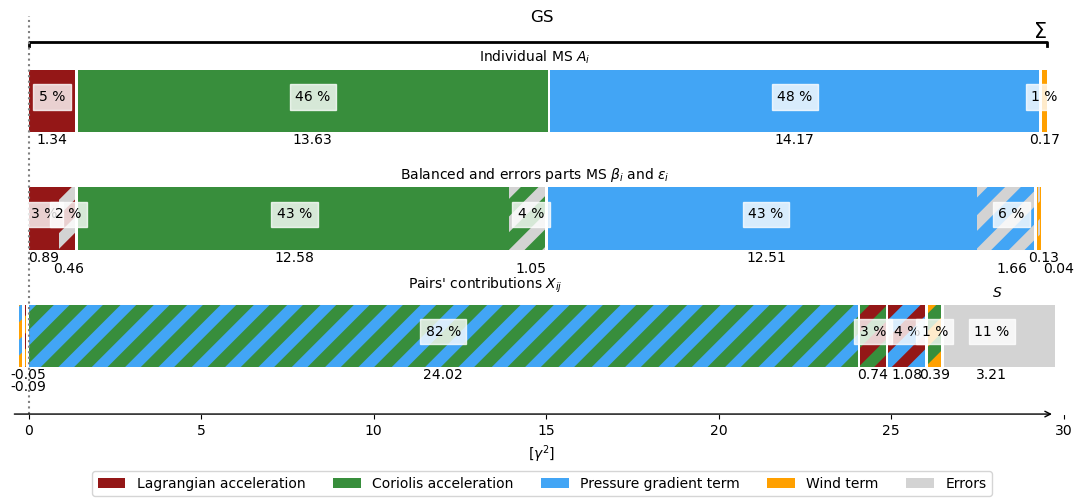

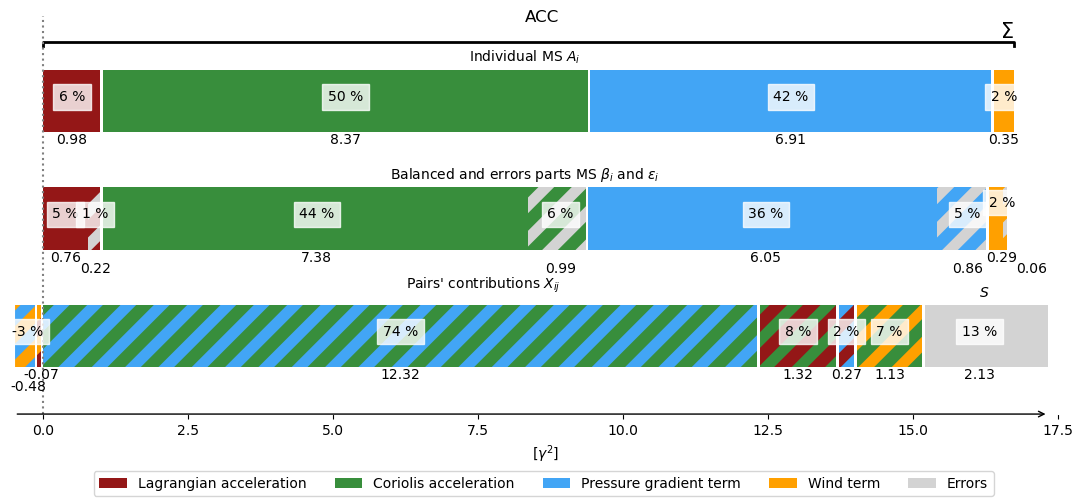

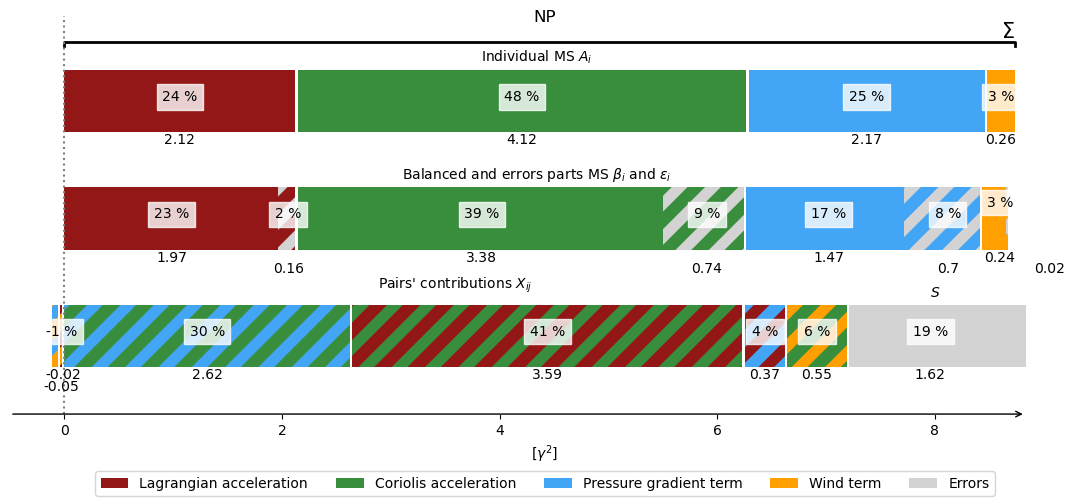

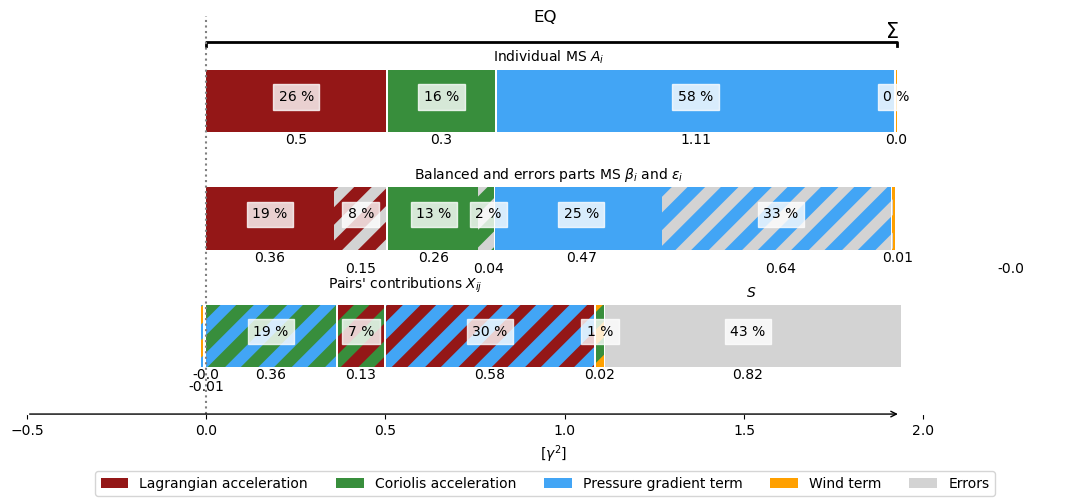

In [9]:
for area in areas:
    print(area)
    df_ = da.loc[area]
    plt.rcParams["axes.edgecolor"] = "w"
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False,)
    synthetic_figure(df_/U2, ax)#, xlim=2.5e-9) 
    fig.legend(ncol=5,loc='lower center')
    fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(area)
    #fig.savefig(f"../images_all/synth_alg{area.replace(' ','_')}.png",bbox_inches='tight',   dpi=300)
plt.rcParams["axes.edgecolor"] = "k"

In [10]:
handles, labels = ax.get_legend_handles_labels()

In [51]:
def synthetic_figure_3lineonly(df, ax, xlim=None, aviso=False) :
    from histlib.cstes import U
    U2 =U**2
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    
    ts = df['sigma']
    print(ts)
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400

    #b = 1e-10
    
    
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 8
    plt.rcParams['hatch.color'] = c0['ggx']
    ax.barh(0, df['X_cor_ggx'], color=c0['cor'], hatch='/')
    plt.rcParams['hatch.color'] = c0['cor']
    ax.barh(0, df['X_acc_cor'], color=c0['acc'], hatch='/', left = df['X_cor_ggx']+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, df['X_acc_ggx'], color=c0['ggx'], hatch='/', left = df['X_cor_ggx']+df['X_acc_cor']+2*b)
    plt.rcParams['hatch.color'] = c0['wd']
    ax.barh(0, df['X_cor_wd'], color=c0['cor'], hatch='/', left = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+3*b)
    ax.barh(0, df['S'], label='Errors', color='lightgrey', left = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+df['X_cor_wd']+4*b)
    #negative contribution
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, -df['X_acc_wd'], color=c0['wd'], hatch='/', left = df['X_acc_wd']-b)
    plt.rcParams['hatch.color'] = c0['ggx']
    ax.barh(0, -df['X_ggx_wd'], color=c0['wd'], hatch='/', left = df['X_acc_wd']+df['X_ggx_wd']-2*b)
    

    tts = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+df['X_cor_wd']+4*b+df['S']
    print(tts)
    sum_pairs = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+df['X_cor_wd']+3*b
    #ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')

    
    #accolade
    c = 1e-12
    id1 = 0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    #ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + df['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    from itertools import combinations
    correlation = list(combinations(['acc', 'cor', 'ggx', 'wd'], 2))
    key = ['X_cor_ggx', 'X_acc_cor','X_acc_ggx','X_cor_wd']
    for i in range(len(key)) :
        d=0
        if aviso and key[i]== 'X_acc_ggx' : d = -0.1*a
        
        if abs(int(np.rint((df[key[i]]/ts)*100)))>0: #does not plot percentage below 1%
            ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 0+d*2, f'{int(np.rint((df[key[i]]/ts)*100))} %', ha='center', bbox=bbox)
        
        ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 0-0.6+d, f'{np.round(df[key[i]],2)}', ha='center')
        
    #negative contribution     
    key = ['X_acc_wd', 'X_ggx_wd']
    for i in range(len(key)) :
        if abs(int(np.rint((df[key[i]]/ts)*100)))>0:
            ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 0, f'{int(np.rint((df[key[i]]/ts)*100))} %', ha='center', bbox=bbox)
        d=0        
        if i%2 ==1 : d=-0.15*a
        ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 0-0.6+d, f'{np.round(df[key[i]],2)}', ha='center')
    
    key = ['X_cor_ggx', 'X_acc_cor','X_acc_ggx','X_cor_wd']
    ax.text(sum([df[v] for v in key])+df['S']/2+i*b, 0, f'{int(np.rint((df["S"]/ts)*100))} %', ha='center', bbox=bbox)
    ax.text(sum([df[v] for v in key])+df['S']/2+i*b, 0-0.6, f'{np.round(df["S"],2)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    ax.axvline(0, ls=':', c='grey')
    ax.set_xlim(-0.05, xlim+0.5)
    ax.set_ylim(-0.9, 0.6)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(1,0),xytext=(0,0), xycoords = 'axes fraction', arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    #ax.set_xlabel(r'$[\gamma^2]$')

29.307659710805815
29.74141142688633
16.624412789124516
17.339972212403744
8.67422949987564
8.833677734855456
1.911642793056371
1.9366758039730412


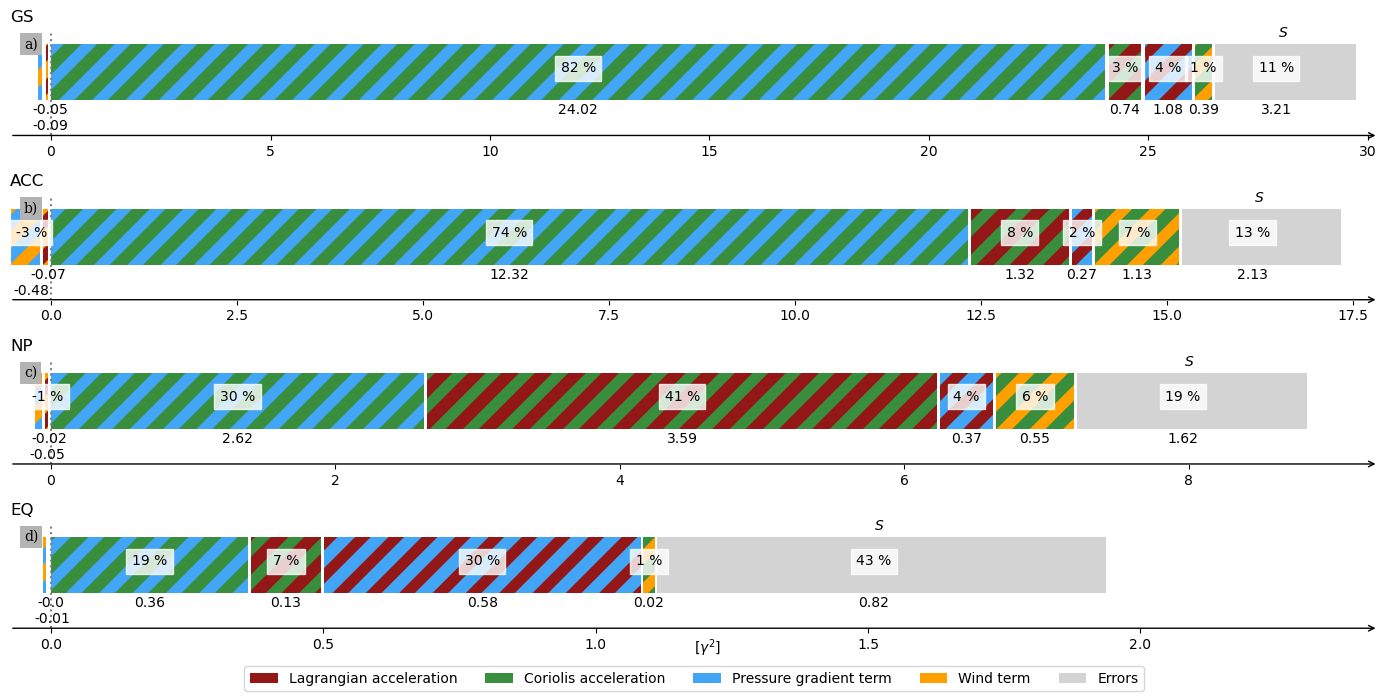

In [57]:
plt.rcParams["axes.edgecolor"] = "w"
fig, axs = plt.subplots(4,1, figsize=(14,7))

axs = axs.flatten()
i=0
pb_text=True
letter=['a', 'b', 'c', 'd']
for area in areas:
    ax=axs[i]
    df_ = da.loc[area]
    synthetic_figure_3lineonly(df_/U2, ax)#, xlim=2.5e-9) 
    ax.set_title(area, loc='left')
    #ax.set_xlabel('')
    put_fig_letter(fig, ax, letter[i])
    i+=1
    pb_text=False

# align x origin 
align.xaxes(axs[0], 0, axs[1], 0, 0.03)
align.xaxes(axs[1], 0, axs[2], 0, 0.03)
align.xaxes(axs[2], 0, axs[3], 0, 0.03)

# xlabel 
fig.text(0.5, 0.06, r'$[\gamma^2]$')

fig.legend(handles=handles, labels=labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/lonlat_synth3line_in_areas_alg.png', bbox_inches='tight',   dpi=300)
plt.rcParams["axes.edgecolor"] = "k"